In [156]:
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
import numpy as np
import pandas as pd
import itertools

"""
Important note: for GP to function properly the y values should have a mean close to zero and a std close to 1
"""

def gaussian_process(x_samples, y_samples, x_estimates,alpha=1e-8):
    """
    x values should be minmax normed in dimensions
    
    Alpha: Value added to the diagonal of the kernel matrix during fitting.
    """    
    gp = GaussianProcessRegressor(alpha=alpha)
    gp.fit(x_samples, y_samples)
    y_mean, y_std = gp.predict(x_estimates, return_std=True)

    y_std = y_std.reshape((-1, 1))

    return y_mean, y_std


def next_parameter_by_ei(y_best, y_mean, y_std, x_choices, goal="minimize"):
    # Calculate expecte improvement from 95% confidence interval
    if goal == "minimize":
        expected_improvement = y_best - (y_mean - 1.96 * y_std)
    elif goal == "maximize":
        expected_improvement = (y_mean + 1.96 * y_std) - y_best

#     expected_improvement[expected_improvement < 0] = 0
    max_index = expected_improvement.argmax()

    # Select next choice
    next_parameter = x_choices[max_index]

    return next_parameter


# Addapted from http://neupy.com/2016/12/17/hyperparameter_optimization_for_neural_networks.html#bayesian-optimization
def hyper_param_selection(func, hyper_parameters_domain, n_iter=5, goal="minimize", gp_alpha=1e-8):
    """
    func: function used to sample network, training and validation data should be global in the notebook
          func should only take hyper parameters in as arguments in same order as hyper_parameters_domain values
    hyper_parameters_domain: dictionary containing all hyper parameters and all their possible values
    n_iter: maximum number of iterations
    goal: [minimize|maximize] states if function needs to be maximized/minimized
    gp_alpha: alpha of gaussian process (GP). Alpha is the number added to the covariance matrix diagnol when fitting
    the GP
    
    ::return::
    X_samples: combination of hyper-paramets
    y_sample: matching func out for those samples
    """
    # set up hyper-param limits
    hyper_parameters_limits = {}
    for k in hyper_parameters_domain:
        hyper_parameters_limits[k] = [hyper_parameters_domain[k].min(), hyper_parameters_domain[k].max()]

    # X_estimates are the parameters that the GP will be estimating
    X_estimates = pd.DataFrame(list(itertools.product(*hyper_parameters_domain.values())),
                               columns=hyper_parameters_domain.keys()).values
    X_estimates_max = X_estimates.max(0)  # todo change to np.max(X_estimates, axis=0, keepdims=True)
    X_estimates_min = X_estimates.min(0)  # todo change to np.min(X_estimates, axis=0, keepdims=True)
    X_estimates_normed = (X_estimates - X_estimates_min) / (X_estimates_max - X_estimates_min)

    # X_samples are the parameters that have been sampled by the Network
    X_samples = pd.DataFrame(list(itertools.product(*hyper_parameters_limits.values())),
                             columns=hyper_parameters_limits.keys()).values
    X_samples_normed = (X_samples - X_estimates_min) / (X_estimates_max - X_estimates_min)

    # sample domain limits from network with un-normed values
    y_samples = []
    for x in X_samples:
        # make sure your definition of train_network lines up with the X_samples variable order
        y_samples.append(func(*x))
    y_samples = pd.DataFrame(y_samples).values
    
    y_best = y_samples.min() if goal == "minimize" else y_samples.max()

    for i in range(n_iter):         
        # sample GP with normed values
        y_mean, y_std = gaussian_process(x_samples=X_samples_normed, 
                                         y_samples=y_samples,
                                         x_estimates=X_estimates_normed,
                                            alpha=gp_alpha)

        #################################################################################
        # only for 1 d array
        plt.figure()
        plt.fill_between(X_estimates.flatten(),(y_mean-y_std).flatten(),(y_mean+y_std).flatten(),alpha=0.2)
        plt.plot(X_estimates,y_mean)
        plt.scatter(X_samples,y_samples,zorder=10,marker="D",s=150,c="m",alpha=0.3)
        plt.show()
        #################################################################################

        # get best new estimate
        X_next_sample = next_parameter_by_ei(y_best, y_mean, y_std, x_choices=X_estimates, goal=goal)

        # sample neural net
        y_next_sample = func(*X_next_sample)

        # add new samples to previous samples and normalise for GP
        X_samples = np.row_stack([X_samples, X_next_sample])
        X_samples_normed = (X_samples - X_estimates_min) / (X_estimates_max - X_estimates_min)

        y_samples = np.row_stack([y_samples, y_next_sample])

        y_best = y_samples.min() if goal == "minimize" else y_samples.max()
        x_arg = y_samples.argmin() if goal == "minimize" else y_samples.argmax()
        X_best = X_samples[x_arg]

        print("Best y:", y_best, " Best Parameters:", X_best)
        print("Current y:", y_samples[-1], " Current Parameters:", X_samples[-1])

        # same exact sample
        if (X_samples[-1] - X_samples[-2]).sum() == 0:
            print("Bayesian Optimization Converged")
            break

    # all samples from the network, to view if there are multiple combinations that work well.
    return X_samples, y_samples


In [157]:
np.random.randn(1)

array([-0.4624265])

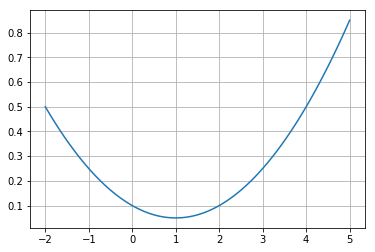

x:5.0 y:0.8500000000000001


In [158]:
def loss(x0): 
    return (((x0 + 2)*(x0 - 4)/10 + 3)-2.)/2
x = np.linspace(-2,5,100)
y = loss(x)
plt.plot(x,y)
plt.grid()
plt.show()


print(f"x:{x[np.argmax(y)]} y:{y[np.argmax(y)]}")
def train_network(hyper_param0):
    return loss(hyper_param0)

In [159]:
hyper_parameters_domain = {
    "x0": x,
}

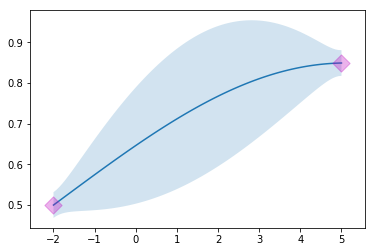

Best y: 0.07222222222222219  Best Parameters: [0.33333333]
Current y: [0.07222222]  Current Parameters: [0.33333333]


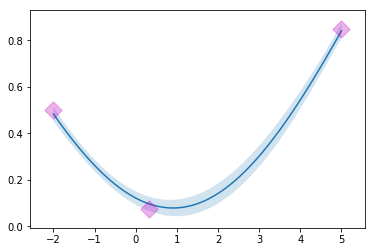

Best y: 0.0500816243240485  Best Parameters: [1.04040404]
Current y: [0.05008162]  Current Parameters: [1.04040404]


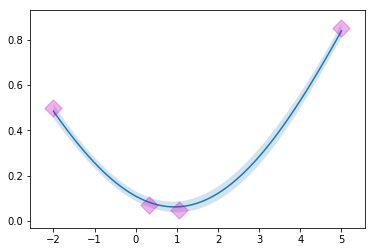

Best y: 0.0500816243240485  Best Parameters: [1.04040404]
Current y: [0.05008162]  Current Parameters: [1.04040404]
Bayesian Optimization Converged


In [160]:
hyper_parameters, losses = hyper_param_selection(func=train_network,
                                             hyper_parameters_domain=hyper_parameters_domain,
                                             n_iter=10, 
                                             goal="minimize",
                                             gp_alpha=.001)

In [86]:
print(f"X_samples: {X_samples}")
print(f"y_samples: {y_samples}")

X_samples: [[-2.        ]
 [ 5.        ]
 [ 1.04040404]
 [ 1.04040404]]
y_samples: [[0.5       ]
 [0.64      ]
 [0.33677585]
 [0.33677585]]
